In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import numpy as np  
from gcs import path_handler as ph
import gcs
import stream_analysis as sa

In [2]:
# the structre of the plot 
def set_up_plot(Nrows):
    fig=plt.figure(figsize=(10,1.5*Nrows + 1))
    gs=gridspec.GridSpec(Nrows,2, width_ratios=[1,0.01],hspace=0.5,wspace=0.05)
    axis=[]
    if Nrows >=3:
        cbar = fig.add_subplot(gs[1:Nrows-1,1])
    else:
        cbar = fig.add_subplot(gs[:,1])
    for i in range(Nrows):
        axis.append(fig.add_subplot(gs[i,0]))
    return fig,axis,cbar

In [3]:
def extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP):
    """
    Here to extract the raw data and transform the stream to tail coordinates in one go
    """

    time_of_interest,nDynTimes=0,2
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv = gcs.extractors.GCOrbits.extract_whole_orbit(orbitpath,montecarlokey=montecarlokey)
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv=sa.tailCoordinates.filter_orbit_by_dynamical_time(tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,time_of_interest,nDynTimes)
    _,xp,yp,zp,vxp,vyp,vzp = gcs.extractors.Stream.extract_old_streams(streampath,internal_dynamics=internal_dynamics,montecarlokey=montecarlokey,NP=NP)
    xT,yT,zT,vxT,vyT,vzT,_ = sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(xp,yp,zp,vxp,vyp,vzp,tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)
    return xT,yT,zT,vxT,vyT,vzT

In [4]:
## Set the global variables
GCname = "Pal5"
NP = int(1e5)
internal_dynamics = "isotropic-plummer"
montecarlokey="monte-carlo-009"


streamPotentials = ["pouliasis2017pii-GCNBody","pouliasis2017pii-NGC2808","pouliasis2017pii-NGC7078","pouliasis2017pii-NGC104","pouliasis2017pii"]
orbitPotentials = ["pouliasis2017pii-GCNBody","pouliasis2017pii-GCNBody","pouliasis2017pii-GCNBody","pouliasis2017pii-GCNBody","pouliasis2017pii"]
NROWS=len(streamPotentials)

In [5]:
# what is the out file name?
outname = "decomposition-{:s}-with-{:d}-gaps".format(montecarlokey,NROWS-2)
outpath = "../paper/"

In [6]:
# load the path names
streampaths = [ph.old_streams(MWpotential=potential_env, GCname=GCname,montecarlokey=montecarlokey,NP=NP) for potential_env in streamPotentials]
orbitpaths = [ph.GC_orbits(MWpotential=potential_env, GCname=GCname) for potential_env in orbitPotentials]


In [7]:
# convert all to tail coordiantes
tailcoordinates = [extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP) for orbitpath,streampath in zip(orbitpaths,streampaths)]

In [8]:
# make the 2D scatter density maps
scatterplots = [ ]
for xT,yT,zT,vxT,vyT,vzT in tailcoordinates:
    XX,YY,H=sa.plotters.binned_density.short_cut(NP,xT,yT,[-10,10],[-1,1])
    H=sa.plotters.binned_density.normalize_density_by_particle_number(H,NP)
    scatterplots.append([XX,YY,H])


In [9]:
# set the properties for the scatter plots

cbarlabel=r"Density [$N_p/N$]"
normalScatterProperties = {
    "alpha":0.9, 
    "s":1,
    "cmap":'rainbow',
    "norm":colors.LogNorm(vmin=1e-5, vmax=1e-3)
    }
AXIS={
    "xlabel":"$x_{tail}$ [kpc]",
    "ylabel":"$y_{tail}$ [kpc]",
    "xlim":[-10,10],
    "ylim":[-0.5,0.5],
    "yticks": [0,0.5],
    "xticks": np.arange(-10,11,2),
    "yticks": np.arange(-0.4,0.5,0.2),
}


In [10]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [11]:
# edit the titles
titles = []
for x in streamPotentials:
    temp = x.split("-")[-1]
    if temp == "GCNBody":
        titles.append("Full")
    elif temp == "pouliasis2017pii":
        titles.append("Reference")
    else:
        titles.append(r"Reference + $\vec{{F}}_\textrm{{{:s}}}$".format(temp))


0
1
2
3


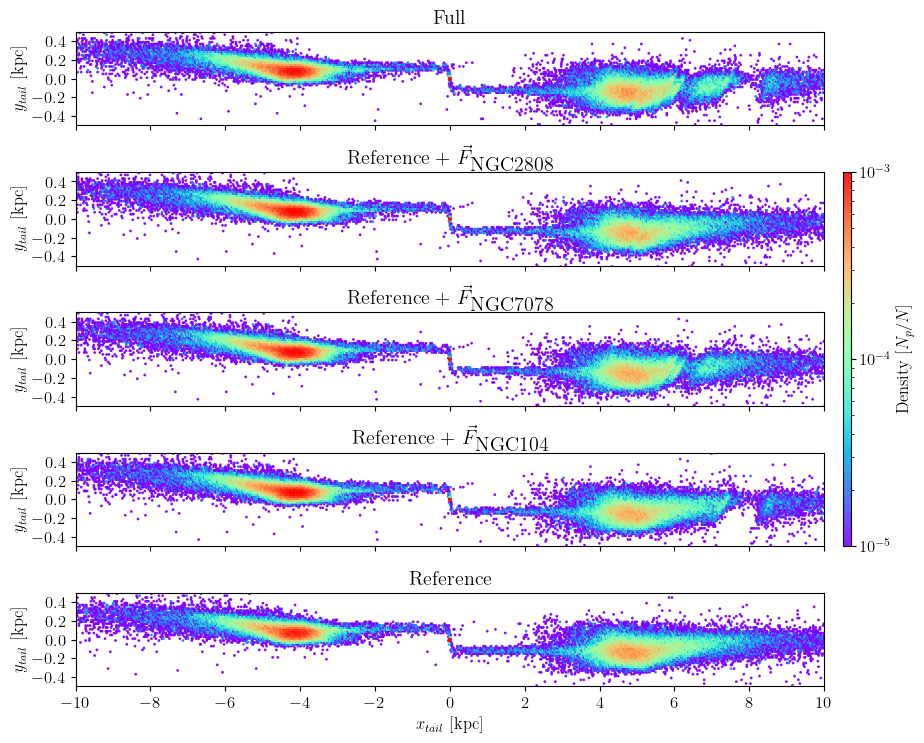

In [12]:
NROWS=len(scatterplots)
fig,axis,cbar=set_up_plot(NROWS)
for i in range(NROWS):
    if i==0:
        im=axis[i].scatter(scatterplots[i][0],scatterplots[i][1],c=scatterplots[i][2],**normalScatterProperties)
    else:
        axis[i].scatter(scatterplots[i][0],scatterplots[i][1],c=scatterplots[i][2],**normalScatterProperties)
    axis[i].set(**AXIS)

cbar=plt.colorbar(im,cax=cbar)
cbar.set_label(cbarlabel)
for i in range(NROWS):
    axis[i].set(**AXIS)
    axis[i].set_title(titles[i])
    if i!=NROWS-1:
        print(i)
        axis[i].set_xticklabels([])
        axis[i].set_xlabel("")



fig.savefig(outpath+outname+".png",dpi=300)